In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np

# Load Fashion MNIST data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))



In [3]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

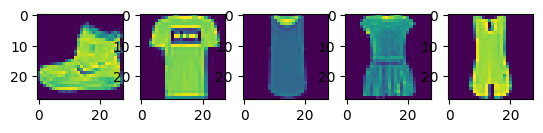

In [4]:
import matplotlib.pyplot as plt
def plotn(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        ax[i].imshow(z.reshape(28,28) if z.size==28*28 else z.reshape(14,14) if z.size==14*14 else z)
    plt.show()

plotn(5,x_train)

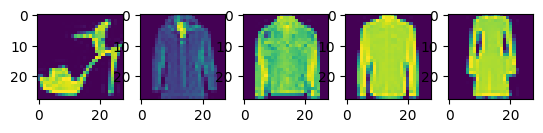

In [5]:
def plotidx(indices, x):
    fig, ax = plt.subplots(1, len(indices))
    for i, z in enumerate(x[indices]):
        ax[i].imshow(z.reshape(28,28) if z.size==28*28 else z.reshape(14,14) if z.size==14*14 else z)
    plt.show()

indices = [9, 19, 29, 39 , 49]
plotidx(indices,x_train)

# Denoising

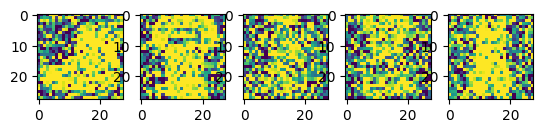

In [6]:
def noisify(data):
  return np.clip(data+np.random.normal(loc=0.5,scale=0.5,size=data.shape),0.,1.)

x_train_noise = noisify(x_train)
x_test_noise = noisify(x_test)

plotn(5,x_train_noise)

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, BatchNormalization, Activation
from tensorflow.keras.losses import binary_crossentropy, mse

input_img = Input(shape=(28,28,1))

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

encoder = Model(input_img, encoded)

input_rep = Input(shape=(4,4,8))

x = Conv2D(8, (3,3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep, decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
history = autoencoder.fit(x_train_noise, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noise, x_test))

Epoch 1/25
469/469 [==============================] - 10s 9ms/step - loss: 0.3991 - val_loss: 0.3411
Epoch 2/25
469/469 [==============================] - 3s 7ms/step - loss: 0.3350 - val_loss: 0.3334
Epoch 3/25
469/469 [==============================] - 3s 7ms/step - loss: 0.3289 - val_loss: 0.3284
Epoch 4/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3247 - val_loss: 0.3253
Epoch 5/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3220 - val_loss: 0.3226
Epoch 6/25
469/469 [==============================] - 4s 8ms/step - loss: 0.3199 - val_loss: 0.3213
Epoch 7/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3184 - val_loss: 0.3206
Epoch 8/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3173 - val_loss: 0.3193
Epoch 9/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3163 - val_loss: 0.3177
Epoch 10/25
469/469 [==============================] - 4s 8ms/step - loss: 0.3155 - val_loss: 0.317

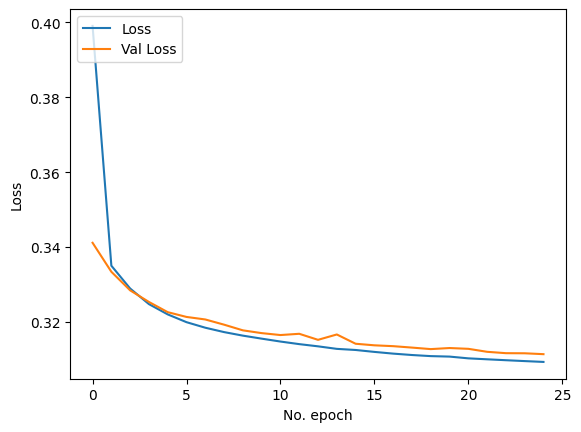

In [12]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

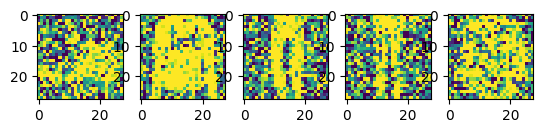

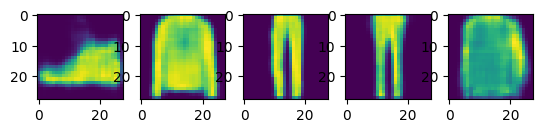

In [13]:
y_test = autoencoder.predict(x_test_noise[0:5], verbose=False)
plotn(5,x_test_noise)
plotn(5,y_test)

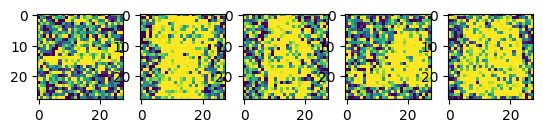

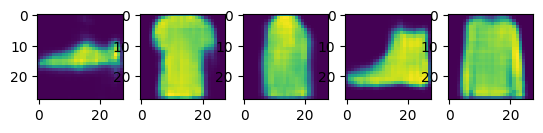

In [14]:
y_test = autoencoder.predict(x_test_noise[indices], verbose=False)
plotidx(indices,x_test_noise)
plotn(5,y_test)

# Super-resolution

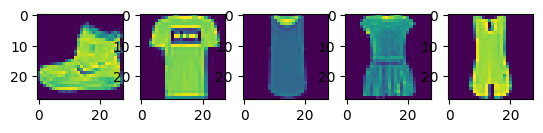

In [15]:
plotn(5, x_train)

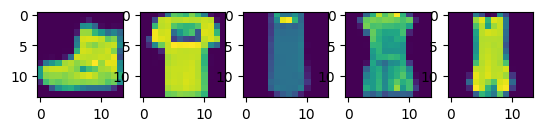

In [16]:
import tensorflow as tf
x_train_lr = tf.keras.layers.AveragePooling2D()(tf.reshape(x_train, (-1, 28, 28, 1))).numpy()
x_test_lr = tf.keras.layers.AveragePooling2D()(tf.reshape(x_test, (-1, 28, 28, 1))).numpy()

plotn(5, x_train_lr)

In [19]:
input_img = Input(shape=(14, 14, 1))

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

encoder = Model(input_img, encoded)

input_rep = Input(shape=(4,4,8))

x = Conv2D(8, (3,3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep, decoded)

super_res_autoencoder = Model(input_img, decoder(encoder(input_img)))
super_res_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

super_res_autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 model_9 (Functional)        (None, 4, 4, 8)           1320      
                                                                 
 model_10 (Functional)       (None, 28, 28, 1)         2481      
                                                                 
Total params: 3801 (14.85 KB)
Trainable params: 3801 (14.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
history_2 = super_res_autoencoder.fit(x_train_lr, x_train,
               epochs=25,
               batch_size=128,
               shuffle=True,
               validation_data=(x_test_lr, x_test))

Epoch 1/25
469/469 [==============================] - 6s 7ms/step - loss: 0.3578 - val_loss: 0.3138
Epoch 2/25
469/469 [==============================] - 4s 8ms/step - loss: 0.3066 - val_loss: 0.3045
Epoch 3/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3004 - val_loss: 0.3001
Epoch 4/25
469/469 [==============================] - 3s 6ms/step - loss: 0.2967 - val_loss: 0.2974
Epoch 5/25
469/469 [==============================] - 3s 6ms/step - loss: 0.2945 - val_loss: 0.2954
Epoch 6/25
469/469 [==============================] - 3s 7ms/step - loss: 0.2928 - val_loss: 0.2941
Epoch 7/25
469/469 [==============================] - 3s 6ms/step - loss: 0.2914 - val_loss: 0.2931
Epoch 8/25
469/469 [==============================] - 3s 6ms/step - loss: 0.2903 - val_loss: 0.2918
Epoch 9/25
469/469 [==============================] - 3s 7ms/step - loss: 0.2893 - val_loss: 0.2908
Epoch 10/25
469/469 [==============================] - 4s 9ms/step - loss: 0.2884 - val_loss: 0.2901

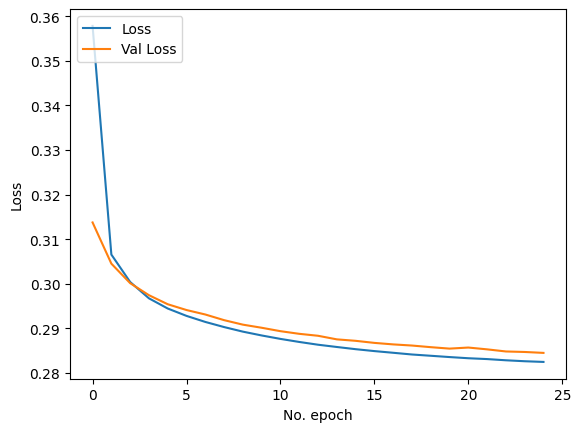

In [21]:
plt.plot(history_2.history['loss'], label='Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

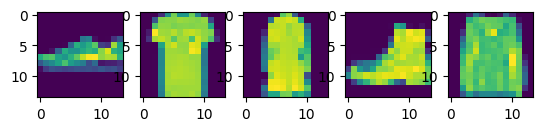

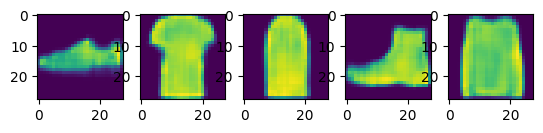

In [22]:
y_test_lr = super_res_autoencoder.predict(x_test_lr[indices], verbose=False)
plotidx(indices, x_test_lr)
plotn(5, y_test_lr)